### 一連の処理は以下の通り。

### 1.前処理を行わずに、ランダムフォレストで重要変数を確認
### 2.重要ではない変数を除いて、精度の向上を確認
### 3.示唆の抽出を行う
### 4.業務効率化の観点からconfusionマトリックスを確認

In [1]:
import numpy as np
import pandas as pd

#StandardScalerは参考にある標準化のためにインポート
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

#不均衡データの処理をするために使用
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
#行列カウント
df.shape

(6362620, 11)

In [4]:
#typeとisFraudの集計により、CASH_OUTとTRANSFERのみがisFraudに関与することがわかる
print(pd.crosstab(df['type'], df['isFraud']))

isFraud         0     1
type                   
CASH_IN   1399284     0
CASH_OUT  2233384  4116
DEBIT       41432     0
PAYMENT   2151495     0
TRANSFER   528812  4097


In [5]:
#isFraudと関与しないtypeをデータより削除
df=df[df["type"]!="CASH_IN"]
df=df[df["type"]!="DEBIT"]
df=df[df["type"]!="PAYMENT"]

In [6]:
#削除の検証
print(np.unique(df.type))
len(df.index)

['CASH_OUT' 'TRANSFER']


2770409

In [7]:
#データ整備
type_mapping = {'CASH_OUT':1,'TRANSFER':2}

df['type'] = df['type'].map(type_mapping)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,2,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1,0
3,1,1,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1,0
15,1,1,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0,0
19,1,2,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0,0
24,1,2,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0,0


In [8]:
#欠損値（値がないものでNaNと表記されるもの）カウント
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [9]:
df['isFraud'].value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [10]:
X = df.iloc[:,[0,1,2,4,5,7,8,10] ]
y = df.iloc[:, [9]]

In [11]:
y.head()

,isFraud
2,1
3,1
15,0
19,0
24,0


## trainデータとテストデータの分離

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [13]:
y_train['isFraud'].value_counts()

0    1381117
1       4087
Name: isFraud, dtype: int64

In [14]:
# ランダムにunder-sampling
positive_count_train = y_train['isFraud'].sum()
rus = RandomUnderSampler(ratio={0:positive_count_train*9, 1:positive_count_train}, random_state=0)
X_train_resampled, y_train_resampled = rus.fit_sample(X_train, y_train)
print('X_train_resampled.shape: {}, y_train_resampled: {}'.format(X_train_resampled.shape, y_train_resampled.shape))
print('y_train_resample:\n{}'.format(pd.Series(y_train_resampled).value_counts()))

C:\Users\yin.wu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_train_resampled.shape: (40870, 8), y_train_resampled: (40870,)
y_train_resample:
0    36783
1     4087
dtype: int64


In [15]:
# ランダムフォレストにて学習
rfc = RandomForestClassifier(random_state=0, n_jobs=-1)
rfc.fit(X_train_resampled, y_train_resampled)

print('Train score: {:.4f}'.format(rfc.score(X_train_resampled, y_train_resampled)))
print('Test score: {:.4f}'.format(rfc.score(X_test, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, rfc.predict(X_test))))
print('ROC-AUC Score {:.4f}'.format(roc_auc_score(y_test, rfc.predict(X_test))))

Train score: 0.9987
Test score: 0.9974
Confusion matrix:
[[1377887    3192]
 [    423    3703]]
ROC-AUC Score 0.9476


## 重要変数の可視化

In [16]:
feat_labels = X_test.columns[0:]
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_test.shape[1]):
    print("%2d) %-*s %f" %
        (f+1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) oldbalanceOrg                  0.358875
 2) newbalanceDest                 0.212751
 3) amount                         0.151669
 4) step                           0.102287
 5) oldbalanceDest                 0.085907
 6) type                           0.057450
 7) newbalanceOrig                 0.031062
 8) isFlaggedFraud                 0.000000


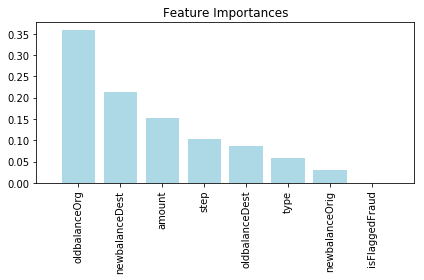

In [17]:
plt.title('Feature Importances')
plt.bar(range(X_test.shape[1]),importances[indices], color='lightblue', align='center')
plt.xticks(range(X_test.shape[1]),feat_labels[indices],rotation=90)
plt.xlim([-1,X_test.shape[1]])
plt.tight_layout()
plt.show()

## 除いた変数を使って再度学習し、精度の向上を確認する。

In [18]:
#isFlaggedFraudは重要度が低いため取り除く
X1 = df.iloc[:, [0,1,2,4,5,7,8]]
y = df.iloc[:, [9]]

In [19]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.5, random_state=0)

positive_count_train = y_train['isFraud'].sum()
rus = RandomUnderSampler(ratio={0:positive_count_train*9, 1:positive_count_train}, random_state=0)
X_train_resampled, y_train_resampled = rus.fit_sample(X1_train, y_train)
print('X_train_resampled.shape: {}, y_train_resampled: {}'.format(X_train_resampled.shape, y_train_resampled.shape))
print('y_train_resample:\n{}'.format(pd.Series(y_train_resampled).value_counts()))

rfc = RandomForestClassifier(random_state=0, n_jobs=-1)
rfc.fit(X_train_resampled, y_train_resampled)

print('Train score: {:.4f}'.format(rfc.score(X_train_resampled, y_train_resampled)))
print('Test score: {:.4f}'.format(rfc.score(X1_test, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, rfc.predict(X1_test))))
print('ROC-AUC Score {:.4f}'.format(roc_auc_score(y_test, rfc.predict(X1_test))))

C:\Users\yin.wu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_train_resampled.shape: (40870, 7), y_train_resampled: (40870,)
y_train_resample:
0    36783
1     4087
dtype: int64
Train score: 0.9991
Test score: 0.9971
Confusion matrix:
[[1377513    3566]
 [    416    3710]]
ROC-AUC Score 0.9483


## 余計な変数を除くとtrainデータに対する精度の向上が見られたが、testデータには見られない
## 過学習の傾向があるが、ROC-AUCは向上

## 当初の依頼に対する答えを用意するための追加検討事項
- 重要変数と、isFraudの関係は？（比例又は反比例）
- 精度解前後のconfusion matrixから何が言えるか？(誤検知と見逃しの件数の位置づけ)

## (参考)標準化を実施する例 confusion_matrixの内訳は変わる

In [20]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.5, random_state=0)

In [21]:
#標準化
sc = StandardScaler()
X1_train_std = sc.fit_transform(X1_train)
X1_test_std = sc.transform(X1_test)

In [22]:
# ランダムにunder-sampling
positive_count_train = y_train['isFraud'].sum()
rus = RandomUnderSampler(ratio={0:positive_count_train*9, 1:positive_count_train}, random_state=0)
X_train_std_resampled, y_train_resampled = rus.fit_sample(X1_train_std, y_train)
print('X_train_resampled.shape: {}, y_train_resampled: {}'.format(X_train_resampled.shape, y_train_resampled.shape))
print('y_train_resample:\n{}'.format(pd.Series(y_train_resampled).value_counts()))


rfc = RandomForestClassifier(random_state=0, n_jobs=-1)
rfc.fit(X_train_std_resampled, y_train_resampled)

print('Train score: {:.4f}'.format(rfc.score(X_train_std_resampled, y_train_resampled)))
print('Test score: {:.4f}'.format(rfc.score(X1_test_std, y_test)))
print('Confusion matrix:\n{}'.format(confusion_matrix(y_test, rfc.predict(X1_test_std))))
print('ROC-AUC Score {:.4f}'.format(roc_auc_score(y_test, rfc.predict(X1_test_std))))

C:\Users\yin.wu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


X_train_resampled.shape: (40870, 7), y_train_resampled: (40870,)
y_train_resample:
0    36783
1     4087
dtype: int64
Train score: 0.9991
Test score: 0.9971
Confusion matrix:
[[1377512    3567]
 [    417    3709]]
ROC-AUC Score 0.9482


## isFraudと重要変数間の関係

Text(0.5,0,'oldbalanceOrg')

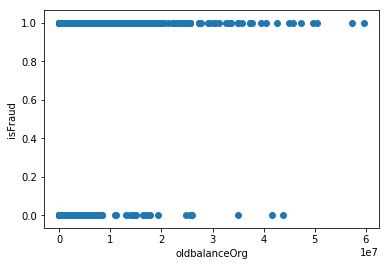

In [23]:
plt.scatter(df["oldbalanceOrg"], df["isFraud"])
plt.ylabel("isFraud")
plt.xlabel("oldbalanceOrg")

Text(0.5,0,'newbalanceDest')

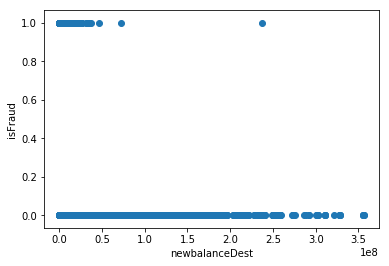

In [24]:
plt.scatter(df["newbalanceDest"], df["isFraud"])
plt.ylabel("isFraud")
plt.xlabel("newbalanceDest")

## 重要変数と目的変数間に単純な関係は見られない
## 次の策として、主成分分析の実施

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [26]:
#主成分を指定して、PCAインスタンスを生成
n=2
pca = PCA(n_components=n)
#ロジスティック回帰のインスタンスを生成
lr=LogisticRegression()
#トレーニングデータやテストデータをPCAに適合させる
X1_train_pca = pca.fit_transform(X1_train_std)
X1_test_pca = pca.fit_transform(X1_test_std)

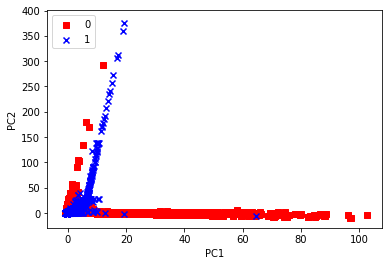

In [27]:
colors = ['r','b','g']
markers = ['s','x','o']

for l,c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X1_train_pca[y_train.isFraud == l,0], X1_train_pca[y_train.isFraud == l,1], 
               c=c, label=l, marker=m)
    
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper left')
plt.show()

## 第2主成分の値が高いほどFraudの可能性が高いことが示された

## 続いて、第2主成分の構成を調べ、Fraudであるデータの特徴を分析する（主成分の固有値分解）

In [33]:
# numpy.linalg パッケージを読み込み
from numpy import linalg as LA

#主成分を指定して、PCAインスタンスを生成
n=7
pca = PCA(n_components=n)
X1_std = sc.transform(X1)
#トレーニングデータやテストデータをPCAに適合させる
X1_pca = pca.fit_transform(X1_std)

In [34]:
#共分散行列を作成
cov_mat = np.cov(X1_pca.T)
#固有値と固有ベクトルを計算
eigen_vals, eigen_vecs = LA.eig(cov_mat.T)

print ('\nEigenValues \n%s' % eigen_vals)
print ('\nEigenVectors \n%s' %eigen_vecs)


EigenValues 
[ 2.30710012  1.61196023  1.07280515  0.99544968  0.60310359  0.19149857
  0.0078913 ]

EigenVectors 
[[  1.00000000e+00   8.95907153e-15  -9.34317699e-14  -1.34466780e-14
    2.32685656e-14  -1.83688748e-16  -7.09894742e-18]
 [  9.02428939e-15  -1.00000000e+00  -1.71649648e-14  -2.28161219e-15
    1.11924922e-15   3.13255320e-16  -1.35990493e-17]
 [ -9.26862704e-14   1.73774128e-14  -1.00000000e+00   3.21863205e-13
   -1.48142720e-13   7.95517242e-17  -1.54560075e-18]
 [ -1.33806515e-14   2.02131026e-15  -3.23022802e-13  -1.00000000e+00
   -2.16999217e-14   3.07350162e-16   1.12877025e-18]
 [ -2.32646181e-14   1.05608927e-15  -1.48918092e-13  -2.16446689e-14
    1.00000000e+00   1.51879902e-15   3.71430139e-17]
 [ -1.83688748e-16  -3.19292897e-16  -1.24819720e-16  -2.28942040e-16
    1.48201307e-15  -1.00000000e+00   3.24248392e-17]
 [  7.09894742e-18  -1.59666416e-17  -6.04061525e-19   1.70378508e-17
   -3.21378810e-17   5.75975275e-18   1.00000000e+00]]


In [35]:
pd.DataFrame(eigen_vecs.T, columns=X1.columns)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,1.000000e+00,9.024289e-15,-9.268627e-14,-1.338065e-14,-2.326462e-14,-1.836887e-16,7.098947e-18
1,8.959072e-15,-1.000000e+00,1.737741e-14,2.021310e-15,1.056089e-15,-3.192929e-16,-1.596664e-17
2,-9.343177e-14,-1.716496e-14,-1.000000e+00,-3.230228e-13,-1.489181e-13,-1.248197e-16,-6.040615e-19
3,-1.344668e-14,-2.281612e-15,3.218632e-13,-1.000000e+00,-2.164467e-14,-2.289420e-16,1.703785e-17
4,2.326857e-14,1.119249e-15,-1.481427e-13,-2.169992e-14,1.000000e+00,1.482013e-15,-3.213788e-17
5,-1.836887e-16,3.132553e-16,7.955172e-17,3.073502e-16,1.518799e-15,-1.000000e+00,5.759753e-18
6,-7.098947e-18,-1.359905e-17,-1.545601e-18,1.128770e-18,3.714301e-17,3.242484e-17,1.000000e+00


## 第2主成分の構成要素の可視化

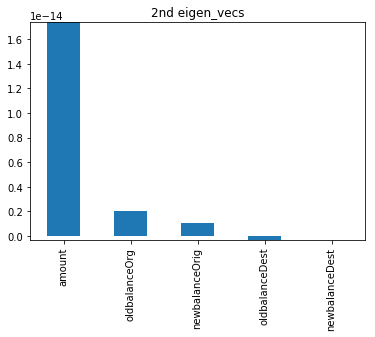

In [36]:
pd.DataFrame(eigen_vecs.T, columns=X1.columns).iloc[1, 2:].plot(kind="bar", title="2nd eigen_vecs");

金額以外に第2主成分の構成要素となっている項目は送り元の取引前残高である。
これと第2主成分の関係性を可視化してみる。

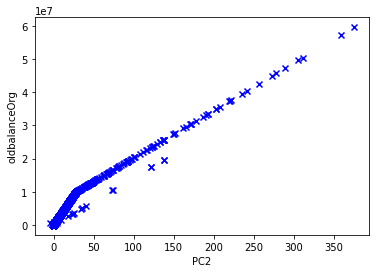

In [37]:
#PC2と送り元の取引前残高の関係性を見る-Fraudの場合
PC2 = X1_pca[:,1]
oldbalanceOrg = X1.iloc[:,3]

plt.scatter(PC2[y.isFraud == 1], oldbalanceOrg[y.isFraud == 1], 
               c=c, label=l, marker=m)
    
plt.xlabel('PC2')
plt.ylabel('oldbalanceOrg')
plt.show()

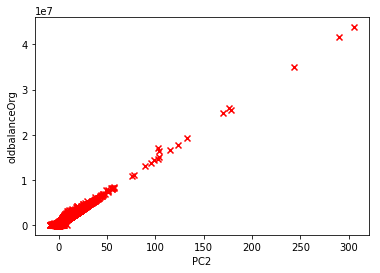

In [38]:
#PC2と送り元の取引前残高の関係性を見る-Fraudでない場合
plt.scatter(PC2[y.isFraud == 0], oldbalanceOrg[y.isFraud == 0], 
               c="r", label=l, marker=m)
    
plt.xlabel('PC2')
plt.ylabel('oldbalanceOrg')
plt.show()

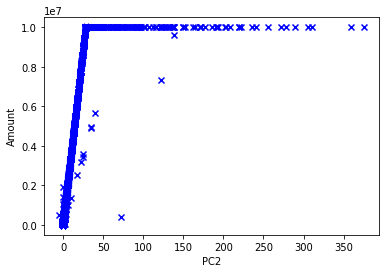

In [39]:
#PC2と金額の関係性を見る-Fraudの場合
PC2 = X1_pca[:,1]
Amount = X1.iloc[:,2]

plt.scatter(PC2[y.isFraud == 1], Amount[y.isFraud == 1], 
               c=c, label=l, marker=m)
    
plt.xlabel('PC2')
plt.ylabel('Amount')
plt.show()

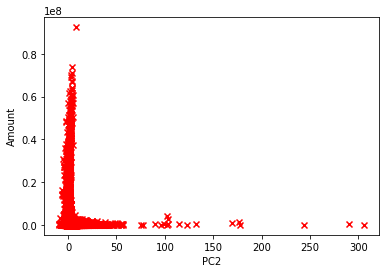

In [40]:
#PC2と金額の関係性を見る-Fraudでない場合
PC2 = X1_pca[:,1]
Amount = X1.iloc[:,2]

plt.scatter(PC2[y.isFraud == 0], Amount[y.isFraud == 0], 
               c="r", label=l, marker=m)
    
plt.xlabel('PC2')
plt.ylabel('Amount')
plt.show()

## 主な構成要素である"金額"と"送り元の取引前残高"と第2主成分の関係性を示したグラフにより、Fraudデータの特徴として、取引金額が高額で且つ送り元の取引前残高が高いことが言える。

## また、予測モデルを使用することにより実業務への影響として
## Randomforestの結果計算されたConfusion Matrixより、予測モデルで不正取引として判定された取引に対してのみ不正検知を実施することで、業務量を大幅に改善することができ、且つ検証作業の精緻化するにもつながる。

例（Training Data)：従来、約139万件全件に対して不正検知を実施していたとすれば、予測モデルにより不正取引として判定された約7千件のデータまで作業量を減らすことができ、割合にすると業務量の99.5%が削減される。また、モデルの精度から全不正取引のうち約9割を不正であると正しく判断できるため、検証作業が精緻化されたとも言える。